In [8]:
from glob import glob
import os
import pandas as pd
from tsai.all import *
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np

DROP_COLS = ['Turn', 'Change', 'Speed', 'ISSUE_DATE', 'X', 'Y']
TARGET_COLS = ["Hazard"]
INDEX_COL = "ISSUE_DATE"


class V2XData():
    def __init__(self, dataset_path = None, dataset_files: list = None, drop_cols: list = None, 
                 target_cols: list = None, test_size: float = 0.5, random_state: int = None):
        self.data_path = dataset_path
        if dataset_files:
            self.dataset_files = dataset_files.copy()
        else:
            self.dataset_files = sorted(glob.glob(os.path.join(self.data_path, "*.csv")))
        
        if not drop_cols:
            self.drop_cols = DROP_COLS.copy()    
        else:
            self.drop_cols = drop_cols
        
        if not target_cols:
            self.target_cols = TARGET_COLS.copy()
        else:
            self.target_cols = target_cols
        
        self.test_size = test_size
        self.random_state = random_state
        self.files_num = len(self.dataset_files)
        
        print(f"loaded {len(self.dataset_files)} files")
        print(self.dataset_files[:5], "...")
        
    def __getitem__(self, index):
        df = pd.read_csv(self.dataset_files[index]).drop(labels = self.drop_cols, axis=1)
        df.dropna(0, inplace = True)
        print(f'df[{index}] shape: {df.shape}')
        # print(df.info())
        df_filtered = pd.crosstab(df['scene'], df['Hazard'])
        df = df.groupby(df['scene']).filter(lambda x: len(x) == 10)
        df.reset_index(drop=True, inplace=True)
        change_list = list(df_filtered[df_filtered[True] > 0].index)
        df.loc[df['scene'].isin(change_list), 'Hazard'] = True
        
        y = df['Hazard'].iloc[::10]
        y = y.astype(int)
        y = y.to_numpy()
        
        X = df.groupby(df["scene"]).apply(lambda x: x.drop(["scene", "Hazard"], axis=1).values)
        X = np.array(X.tolist())
        X = np.array([scene.transpose() for scene in X])
        
        splits = self.get_splits(X, test_size = self.test_size, random_state = self.random_state)
        
        return X, y, splits, df
    
    def get_splits(self, X, test_size: float = 0.5, random_state: int = None):
        X_train, X_valid = train_test_split(X, test_size=test_size, random_state=random_state)
        splits = get_predefined_splits(X_train, X_valid)
        return splits
    
    @staticmethod
    def get_data_info(X, y, splits = None):
        print('Dataset Info is...')
        print(f'X shape: {X.shape}, y shape: {y.shape}') 
        if(splits):
            print(f'splits: (train: (#{len(splits[0])})({splits[0][0]}, ...)) (test: (#{len(splits[1])})({splits[1][0]}, ...))')
        print(f'# True in y: {np.unique(y, return_counts=True)}')
        print('Dataset Info is done.')
    
    def get_all_item(self):
        X_sum, y_sum = [], []
        for idx in range(self.files_num):
            X, y, _, _ = self.__getitem__(idx)
            X_sum.append(X)
            y_sum.append(y)
            
        X_sum = np.concatenate(X_sum)
        y_sum = np.concatenate(y_sum)
        splits = self.get_splits(X_sum, test_size = self.test_size, random_state = self.random_state)
        return X_sum, y_sum, splits
    

loaded 46 files
['./data/Sejong\\0901_5RNBVU80.csv', './data/Sejong\\0901_OKG5RJW0.csv', './data/Sejong\\0902_5RNBVU80.csv', './data/Sejong\\0902_9CU6AVIU.csv', './data/Sejong\\0903_5RNBVU80.csv'] ...
df[2] shape: (10459, 13)
Dataset Info is...
X shape: (1045, 11, 10), y shape: (1045,)
splits: (train: (#522)(0, ...)) (test: (#523)(522, ...))
# True in y: (array([0, 1]), array([838, 207], dtype=int64))
Dataset Info is done.
X      - shape: [522 samples x 11 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (523, 11, 10)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [522, 523]  overlap: False


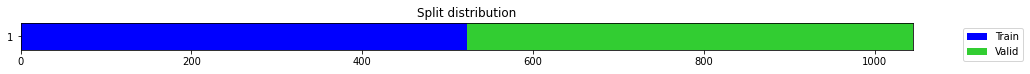

In [9]:
files_path = './data/Sejong'

v2xdata = V2XData(files_path)
X, y, splits, df = v2xdata[2]
v2xdata.get_data_info(X, y, splits)

X_train, X_valid = X[splits[0]], X[splits[1]]
check_data(X_train, X_valid, splits=splits)

epochs = 200

df[0] shape: (13304, 13)
df[1] shape: (5401, 13)
df[2] shape: (10459, 13)
df[3] shape: (3862, 13)
df[4] shape: (1500, 13)
df[5] shape: (8240, 13)
df[6] shape: (10509, 13)
df[7] shape: (4649, 13)
df[8] shape: (4649, 13)
df[9] shape: (9233, 13)
df[10] shape: (6800, 13)
df[11] shape: (8891, 13)
df[12] shape: (9132, 13)
df[13] shape: (10359, 13)
df[14] shape: (6070, 13)
df[15] shape: (7687, 13)
df[16] shape: (7746, 13)
df[17] shape: (7746, 13)
df[18] shape: (6070, 13)
df[19] shape: (8891, 13)
df[20] shape: (9041, 13)
df[21] shape: (8101, 13)
df[22] shape: (7746, 13)
df[23] shape: (12240, 13)
df[24] shape: (8101, 13)
df[25] shape: (3862, 13)
df[26] shape: (8891, 13)
df[27] shape: (6800, 13)
df[28] shape: (7687, 13)
df[29] shape: (6800, 13)
df[30] shape: (10359, 13)
df[31] shape: (7746, 13)
df[32] shape: (9041, 13)
df[33] shape: (4649, 13)
df[34] shape: (9233, 13)
df[35] shape: (3862, 13)
df[36] shape: (8101, 13)
df[37] shape: (8240, 13)
df[38] shape: (9132, 13)
df[39] shape: (1500, 13)
df[4

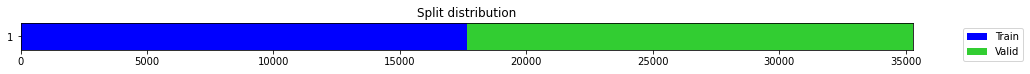

In [10]:
X_all, y_all, splits = v2xdata.get_all_item()
check_data(X_all, y_all, splits=splits)

In [13]:
pd.DataFrame(X_all[0])

,0,1,2,3,4,5,6,7,8,9
0,9220.0,9220.0,9220.0,9220.0,9220.0,9220.0,9220.0,9220.0,9220.0,9220.0
1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,-25.0,-25.0,-24.0,-23.0,-23.0,-22.0,-22.0,-20.0,-18.0,-17.0
3,9.0,12.0,11.0,7.0,7.0,5.0,5.0,3.0,1.0,-2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def learn_model(X, y, splits, model_input, epochs):
    # train with LSTM
    tfms = [TSStandardize(verbose=True), [Categorize()]]
    batch_tfms = TSStandardize(by_sample=True)
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=batch_tfms)
    dls.show_batch()

    model = create_model(model_input, dls = dls)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(epochs, 1e-3)
    learn.plot_metrics()

def multivariate_classification(X, y, splits, epochs):
    X, y, splits = get_classification_data('LSST', split_data=False)
    batch_tfms = TSStandardize(by_sample=True)
    mv_clf = TSClassifier(X, y, splits=splits, path='models', arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
    mv_clf.fit_one_cycle(epochs, 1e-2)
    # mv_clf.export("mv_clf.pkl")
    
def multivariate_classification2(X, y, splits, epochs=20, model=LSTM, lr = 1e-3, metrics=accuracy, lr_find=False):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus"
    X, y, splits = get_classification_data('LSST', split_data=False)
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_sample=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    
    m = create_model(model, dls = dls)
    learn = Learner(dls, m, metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit_one_cycle(epochs, lr)
    learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,2.502557,2.380084,0.399027,00:02
1,2.230416,1.858039,0.520276,00:02
2,1.882560,1.451425,0.587591,00:02
3,1.575112,1.220351,0.616788,00:03
4,1.344291,1.138190,0.640308,00:03
5,1.186853,1.046100,0.662612,00:03
6,1.061898,1.023139,0.671938,00:03
7,0.968912,0.986351,0.682482,00:04
8,0.887143,0.953797,0.684509,00:03
9,0.828400,0.964157,0.674371,00:03


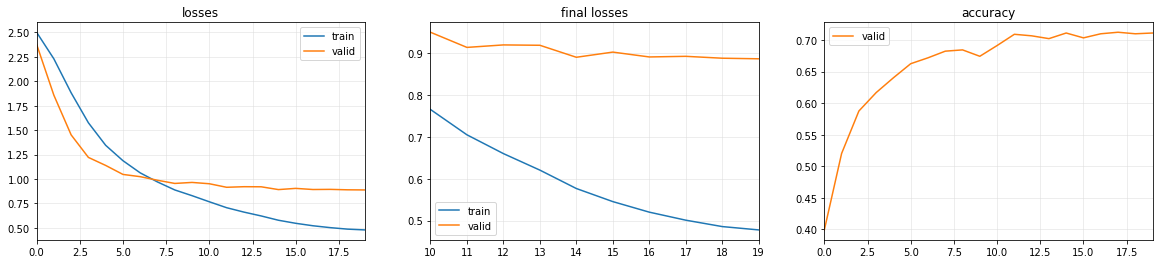

In [24]:
multivariate_classification2(X_all, y_all, splits, model=MLSTM_FCNPlus, lr = 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.528620,2.390708,0.395783,00:02
1,2.276125,1.907099,0.497161,00:02
2,1.940161,1.532959,0.557178,00:02
3,1.627277,1.270307,0.610706,00:02
4,1.386098,1.173301,0.631792,00:02
5,1.216311,1.089077,0.647607,00:02
6,1.079427,1.019157,0.674371,00:02
7,0.982211,1.014431,0.671533,00:02
8,0.896761,0.995434,0.682887,00:02
9,0.835870,0.940989,0.691809,00:02


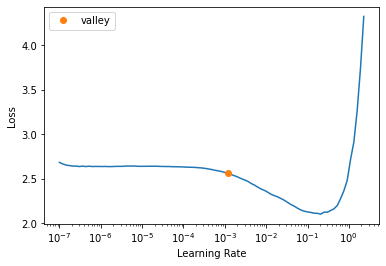

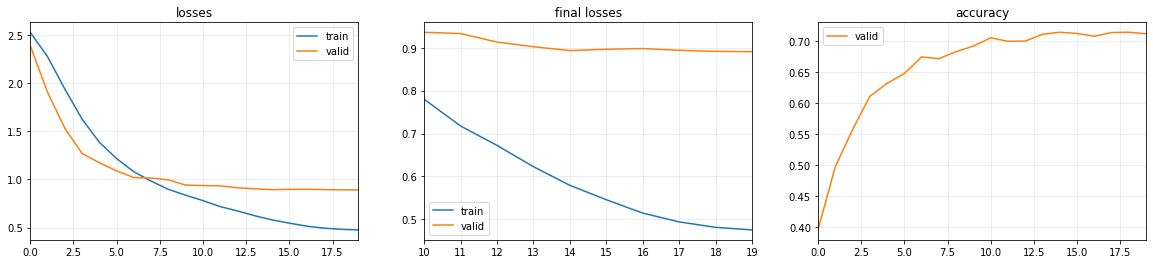

In [6]:
# learn_model(X, y, splits, LSTM_FCNPlus, epochs)
multivariate_classification2(X, y, splits, 20)

epoch,train_loss,valid_loss,accuracy,time
0,2.556702,2.494923,0.279805,00:02
1,2.464319,2.357617,0.340227,00:01
2,2.363309,2.241724,0.388483,00:01
3,2.264211,2.128191,0.446878,00:01
4,2.158790,2.015661,0.484590,00:01
5,2.053171,1.909630,0.529197,00:01
6,1.947015,1.804311,0.551906,00:01
7,1.843663,1.701935,0.564477,00:01
8,1.735643,1.600920,0.578264,00:01
9,1.639053,1.510729,0.585158,00:01


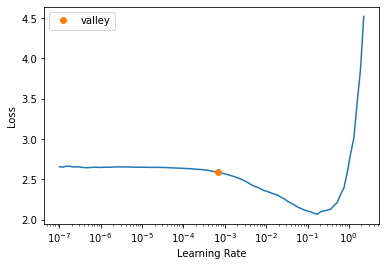

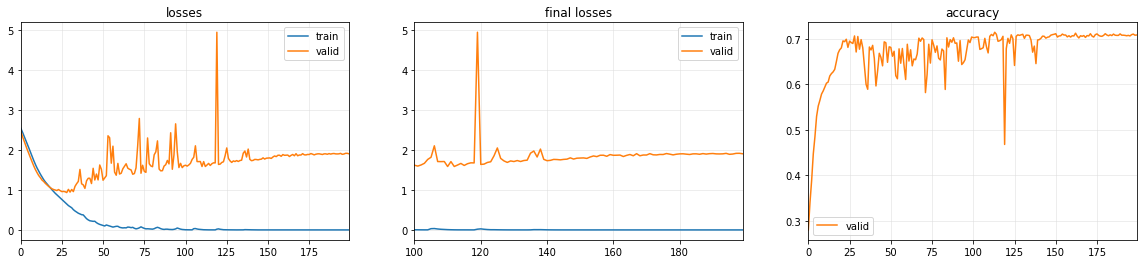

In [35]:
multivariate_classification2(X, y, splits, epochs, lr = 1e-3)

# TS Classification

loaded 46 files
['./data/Sejong\\0901_5RNBVU80.csv', './data/Sejong\\0901_OKG5RJW0.csv', './data/Sejong\\0902_5RNBVU80.csv', './data/Sejong\\0902_9CU6AVIU.csv', './data/Sejong\\0903_5RNBVU80.csv'] ...
df shape: (13304, 15)


epoch,train_loss,valid_loss,accuracy,time
0,0.700168,0.680581,0.789474,00:00
1,0.566783,0.699136,0.210526,00:00
2,0.481034,0.721821,0.210526,00:00
3,0.418984,0.662246,0.789474,00:00
4,0.372125,0.530089,0.789474,00:00
5,0.337703,0.535907,0.789474,00:00
6,0.311377,0.600646,0.789474,00:00
7,0.292386,0.627800,0.789474,00:00
8,0.278862,0.628734,0.789474,00:00
9,0.267493,0.703349,0.789474,00:00


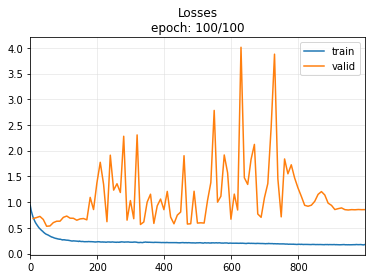

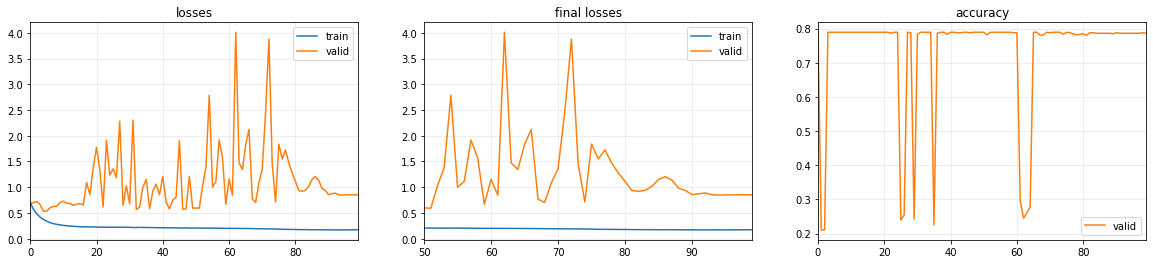

In [7]:
from tsai.data.external import *
from tsai.data.preprocessing import *
from tsai.models.InceptionTimePlus import *

v2xdata = V2XData(files_path)
X, y, splits, _ = v2xdata[0]
batch_tfms = [TSStandardize(by_sample=True)]
learn = TSClassifier(X, y, splits=splits, batch_tfms=batch_tfms, cbs=ShowGraph(), metrics=accuracy)
learn.fit_one_cycle(100, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.610862,0.637526,0.789474,00:00
1,0.543891,0.588012,0.789474,00:00
2,0.480455,0.515660,0.789474,00:00
3,0.419447,0.551365,0.789474,00:00
4,0.367510,0.679785,0.789474,00:00
5,0.335073,0.668797,0.789474,00:00
6,0.310686,0.607035,0.789474,00:00
7,0.293726,0.631922,0.789474,00:00
8,0.279131,0.639701,0.789474,00:00
9,0.268276,0.642383,0.789474,00:00


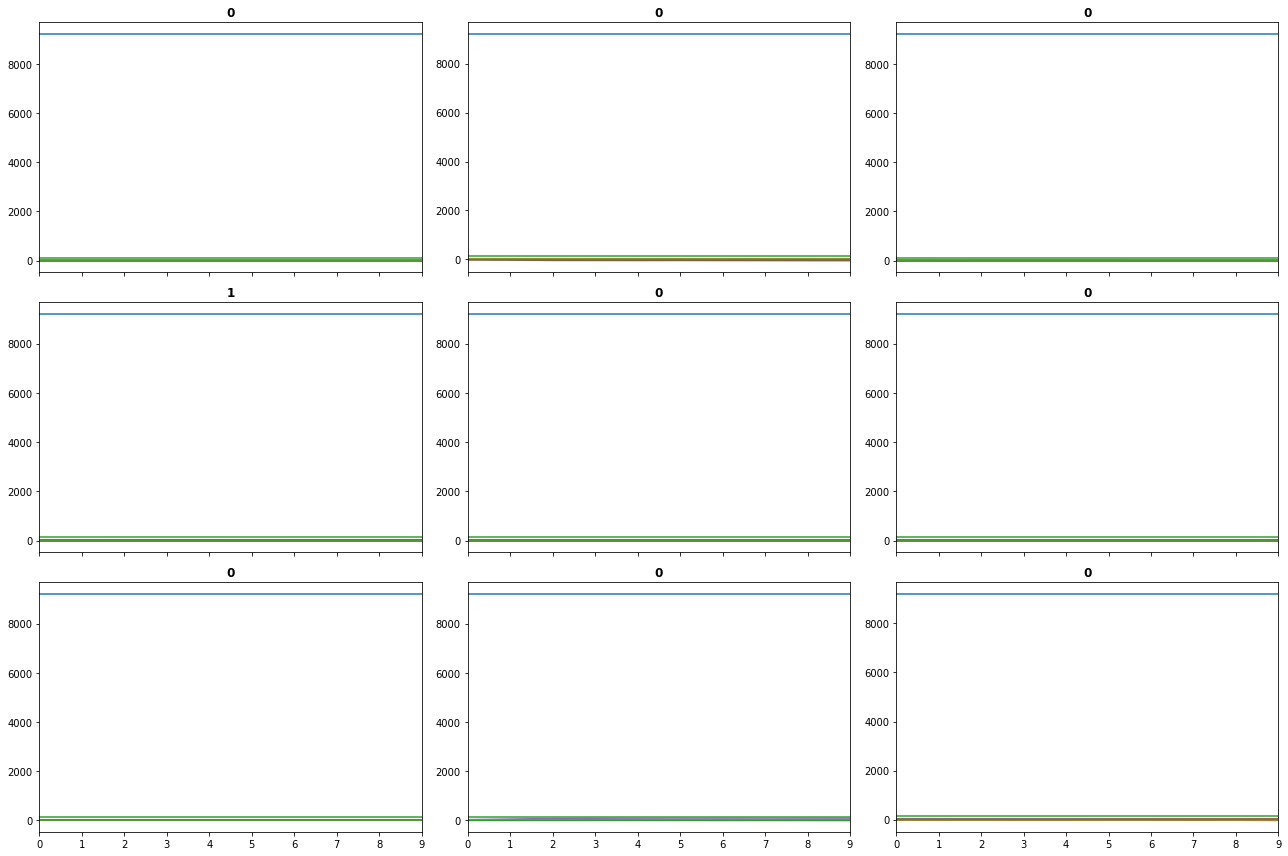

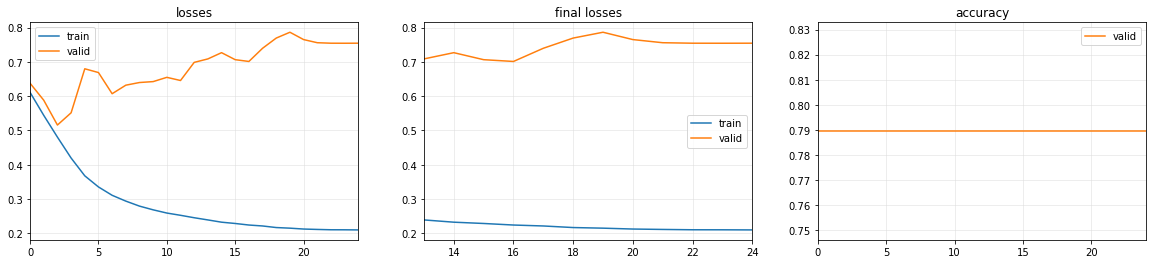

In [16]:
# train with LSTM
tfms = [TSStandardize(verbose=True), [Categorize()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=None)
dls.show_batch()

model = create_model(LSTM_FCN, dls = dls)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, 1e-3)
learn.plot_metrics()

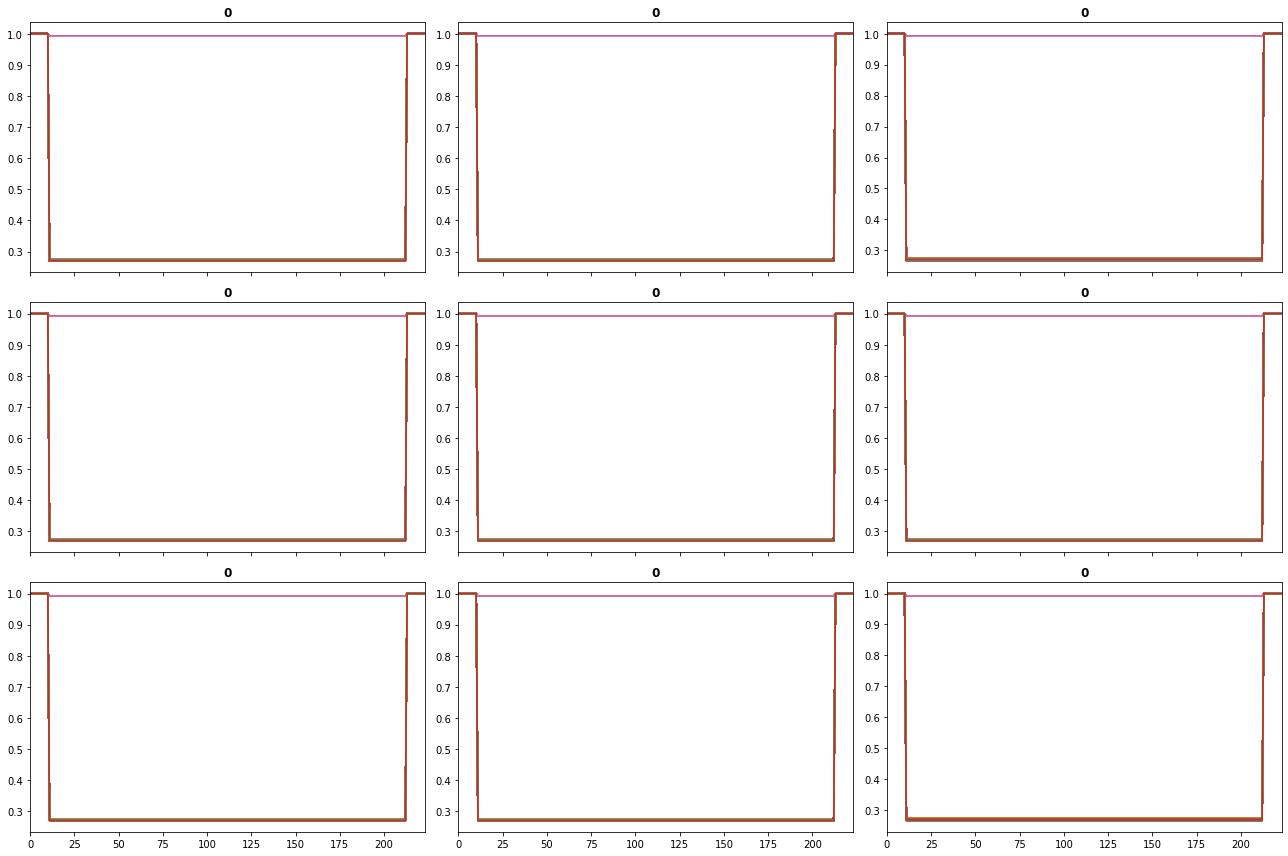

In [15]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMat()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,0.529063,0.648135,0.789474,00:00
1,0.459778,0.666250,0.789474,00:00
2,0.411229,0.667061,0.789474,00:00
3,0.370723,0.639245,0.789474,00:00
4,0.341257,0.533517,0.789474,00:00
5,0.313532,0.534927,0.789474,00:00
6,0.292706,0.591950,0.789474,00:00
7,0.277813,0.636862,0.789474,00:00
8,0.266816,0.742299,0.789474,00:00
9,0.256933,0.916653,0.789474,00:00



training time: 00:00:43


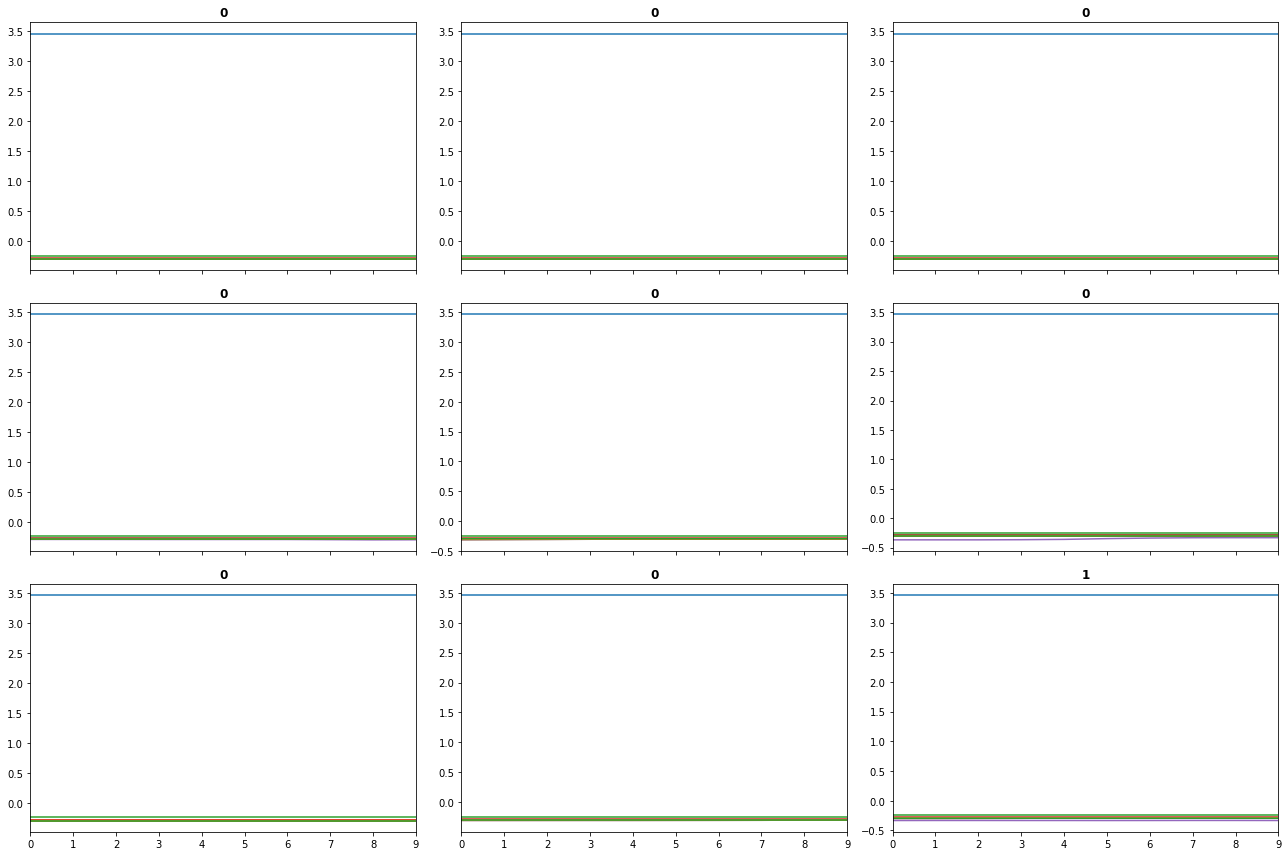

In [76]:
tfms = [None, Categorize()]
batch_tfms = [TSStandardize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

model = create_model(InceptionTime, dls=dls)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(epochs, lr_max=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")